# Looking at SPECTRA factor outputs

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns 
import pickle
import os
import numpy as np
from sklearn.decomposition import PCA
import umap

from collections import defaultdict
from collections import Counter
import itertools

from scipy.signal import find_peaks
from scipy import stats
from diptest import diptest
from scipy.stats import kruskal
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from matplotlib.gridspec import GridSpec

from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

/c4/home/sanjayr/.conda/envs/spectra_kernel/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#spectra imports
import Spectra as spc
from Spectra import Spectra_util as spc_tl
from Spectra import K_est as kst
from Spectra import default_gene_sets

In [5]:
os.chdir("./gabi_rotation")
# Load in the adatas and model
with open('adatas/skin_data_-1cells_10000epochs_bulkTrue_3000genes.pickle', 'rb') as f:
    adata = pickle.load(f)

with open('models/skin_model_-1cells_10000epochs_bulkTrue_3000genes.pickle', 'rb') as f:
    model = pickle.load(f)

# Starting w factor bimodality

In [16]:
def analyze_distributions(data, factor_names=None):
    """
    Analyze and visualize the distribution of scores for each factor on a single plot.
    
    Parameters:
    data : numpy.ndarray
        Array of shape (n_cells, n_factors) containing scores
    factor_names : list, optional
        Names of the factors. If None, will use "Factor 1", "Factor 2", etc.
    
    Returns:
    dict : Dictionary containing bimodality statistics for each factor
    """
    n_cells, n_factors = data.shape
    if factor_names is None:
        factor_names = [f"Factor {i+1}" for i in range(n_factors)]

    results = {}
    for i in range(n_factors):
        factor_data = data[:, i]
        
        # Calculate statistics
        results[factor_names[i]] = {}
        results[factor_names[i]]['mean'] = np.mean(factor_data)
        results[factor_names[i]]['std'] = np.std(factor_data)
        
        # Test for bimodality using Hartigan's dip test
        try:
            dip, pval = diptest(factor_data)
            results[factor_names[i]]['dip_statistic'] = dip
            results[factor_names[i]]['dip_p_value'] = pval
        except ImportError:
            # Alternative bimodality detection using peaks in KDE
            kde = stats.gaussian_kde(factor_data)
            x_range = np.linspace(min(factor_data), max(factor_data), 200)
            y = kde(x_range)
            peaks, _ = find_peaks(y)
            results[factor_names[i]]['num_peaks'] = len(peaks)
            
        results[factor_names[i]]['skewness'] = stats.skew(factor_data)
        #Kurtosis is a descriptive statistic used to help measure how data disperse between a distribution's center and tails, 
        # with larger values indicating a data distribution may have “heavy” tails
        results[factor_names[i]]['kurtosis'] = stats.kurtosis(factor_data)
    return results

cell_score_structure = analyze_distributions(adata.obsm['SPECTRA_cell_scores'], factor_names=list(adata.uns['SPECTRA_overlap'].index))

/c4/home/sanjayr/.conda/envs/spectra_kernel/lib/python3.9/site-packages/diptest/consts.py:702: UserWarning: Sample size exceeds the maximum limit of 72000. Results may not be accurate with precomputed statistical values.
  warnings.warn(


In [17]:
#Turns dictionary into a dataframe
rows = []
for key, metrics in cell_score_structure.items():
    # Create a new dictionary for this row
    row = metrics.copy()  # Copy the metrics dictionary
    row['SPECTRA_factor'] = key  # Add the key as a column
    rows.append(row)

# Convert to DataFrame
factor_attributes = pd.DataFrame(rows)

# Set pathway as index
factor_attributes.set_index('SPECTRA_factor', inplace=True)

# Convert numpy float64 to regular float for better display
float_columns = factor_attributes.select_dtypes(include=[np.float64]).columns
factor_attributes[float_columns] = factor_attributes[float_columns].astype(float)

In [18]:
def extract_cell_type(index):
    parts = index.split('-')
    return parts[2]  # Assuming the cell type is always the third part

# Apply the function to the index and create a new column
factor_attributes['cell_type'] = factor_attributes.index.map(extract_cell_type)

In [19]:
factor_attributes

,mean,std,dip_statistic,dip_p_value,skewness,kurtosis,cell_type
SPECTRA_factor,,,,,,,
0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis,0.000052,0.000110,0.059600,0.0,3.188354,16.281420,global
1-X-global-X-all_retinol_metabolism,0.000049,0.000113,0.061310,0.0,6.395497,229.745626,global
2-X-global-X-all_RIG-I-like-receptor_signaling,0.000720,0.001279,0.073786,0.0,6.209812,83.472146,global
3-X-global-X-all_propanoate_metabolism,0.000415,0.000915,0.092016,0.0,6.471267,76.237432,global
4-X-global-X-all_p53-signaling,0.000885,0.001582,0.056759,0.0,6.020325,70.241998,global
...,...,...,...,...,...,...,...
2098-X-pDC-X-2098,0.000017,0.001091,0.000019,1.0,95.539720,11847.013224,pDC
2099-X-pDC-X-CD8-T_terminal-exhaustion,0.000028,0.002523,0.000011,1.0,127.776660,18936.859141,pDC
2100-X-pDC-X-all_TNF-via-NFkB_signaling,0.000031,0.002771,0.000012,1.0,139.061272,24478.917204,pDC


# Looking at Batch Association

In [ ]:
def batch_association(adata):
    # Create masks based on batch to apply on cell_scores
    batch_labels = adata.obs['batch']
    unique_batches = set(batch_labels)
    batch_masks = {batch: batch_labels == batch for batch in unique_batches}

    cell_scores = adata.obsm['SPECTRA_cell_scores']

    num_factors = cell_scores.shape[1]

    statistics = np.zeros(num_factors)
    p_vals = np.zeros(num_factors)
    prop_variance = np.zeros(num_factors)
    
    k_statistics = np.zeros(num_factors)
    k_p_vals = np.zeros(num_factors)

    #Create dataframe to fit ANOVA OLS model
    df = pd.DataFrame({'factor_scores': np.zeros(cell_scores.shape[0]), 'batch': batch_labels})

    for factor_idx in range(num_factors):
        # Grab a single factor
        factor_scores = cell_scores[:, factor_idx]

        # Create DataFrame for statsmodels
        df['factor_scores'] = factor_scores

        # Running OLS-based ANOVA (dependent is factor scores, batch is the cateogrical variable)
        model = ols('factor_scores ~ C(batch)', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)

        # Extract F-statistic, p-value, and proportion of variance explained
        statistic = anova_table["F"].iloc[0]
        p_val = anova_table["PR(>F)"].iloc[0]
        prop_variance_explained = anova_table['sum_sq'].iloc[0] / anova_table['sum_sq'].sum()

        statistics[factor_idx] = statistic
        p_vals[factor_idx] = p_val
        prop_variance[factor_idx] = prop_variance_explained

        # Running Kruskal-Wallis H test (non-parametric ANOVA)
        batch_groups = [factor_scores[batch_masks[batch]] for batch in unique_batches]
        k_stats, k_p_pval = kruskal(*batch_groups)

        k_statistics[factor_idx] = k_stats
        k_p_vals[factor_idx] = k_p_pval

    # Correct p-values for multiple testing using Benjamini-Hochberg (FDR)
    _, corrected_p_vals, _, _ = multipletests(p_vals, method='fdr_bh')
    _, corrected_k_p_vals, _, _ = multipletests(k_p_vals, method='fdr_bh')

    return statistics, corrected_p_vals, prop_variance, k_statistics, corrected_k_p_vals

anova_statistics, anova_pvals, prop_variance, kruskal_statistics, kruskal_p_vals = batch_association(adata)
factor_attributes['ANOVA statistic (Batch Effect)'] = anova_statistics
factor_attributes['ANOVA Pval (Batch Effect)'] = anova_pvals
factor_attributes['Proportion of Variance (Batch Effect)'] = prop_variance
factor_attributes['Kruskal-Wallis statistic (Batch Effect)'] = kruskal_statistics
factor_attributes['Kruskal-Wallis Pval (Batch Effect)'] = kruskal_p_vals

# Create a column to flag any factor above 5% variance explained by batch that is significant
factor_attributes['significant_batch_effect'] = (factor_attributes['Proportion of Variance (Batch Effect)'] > 0.05) & (factor_attributes['ANOVA Pval (Batch Effect)'] < 0.05)

#Takes ~30 minutes to run, so save to avoid running in future
factor_attributes.to_csv('factor_stats.csv')

In [39]:
factor_attributes

,mean,std,dip_statistic,dip_p_value,skewness,kurtosis,cell_type,ANOVA statistic (Batch Effect),ANOVA Pval (Batch Effect),Kruskal-Wallis statistic (Batch Effect),Kruskal-Wallis Pval (Batch Effect),Proportion of Variance (Batch Effect)
SPECTRA_factor,,,,,,,,,,,,
0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis,0.000052,0.000110,0.059600,0.0,3.188354,16.281420,global,410.006181,0.000000e+00,5799.857760,0.000000e+00,0.015450
1-X-global-X-all_retinol_metabolism,0.000049,0.000113,0.061310,0.0,6.395497,229.745626,global,421.801625,0.000000e+00,5812.665800,0.000000e+00,0.015887
2-X-global-X-all_RIG-I-like-receptor_signaling,0.000720,0.001279,0.073786,0.0,6.209812,83.472146,global,852.577260,0.000000e+00,12557.077250,0.000000e+00,0.031600
3-X-global-X-all_propanoate_metabolism,0.000415,0.000915,0.092016,0.0,6.471267,76.237432,global,1094.638223,0.000000e+00,13878.759392,0.000000e+00,0.040211
4-X-global-X-all_p53-signaling,0.000885,0.001582,0.056759,0.0,6.020325,70.241998,global,650.760119,0.000000e+00,9494.338354,0.000000e+00,0.024301
...,...,...,...,...,...,...,...,...,...,...,...,...
2098-X-pDC-X-2098,0.000017,0.001091,0.000019,1.0,95.539720,11847.013224,pDC,8.427035,8.493107e-14,457.874478,5.095427e-92,0.000322
2099-X-pDC-X-CD8-T_terminal-exhaustion,0.000028,0.002523,0.000011,1.0,127.776660,18936.859141,pDC,24.458572,1.051865e-46,458.173726,4.435675e-92,0.000935
2100-X-pDC-X-all_TNF-via-NFkB_signaling,0.000031,0.002771,0.000012,1.0,139.061272,24478.917204,pDC,26.182662,2.543516e-50,458.300576,4.198211e-92,0.001001


# Start Running Here

In [5]:
#Load factor_attributes here
factor_attributes = pd.read_csv('factor_stats.csv', index_col=0)
factor_attributes

,mean,std,dip_statistic,dip_p_value,skewness,kurtosis,cell_type,ANOVA statistic (Batch Effect),ANOVA Pval (Batch Effect),Kruskal-Wallis statistic (Batch Effect),Kruskal-Wallis Pval (Batch Effect),Proportion of Variance (Batch Effect),significant_batch_effect
SPECTRA_factor,,,,,,,,,,,,,
0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis,0.000052,0.000110,0.059600,0.0,3.188354,16.281420,global,410.006181,0.000000e+00,5799.857760,0.000000e+00,0.015450,False
1-X-global-X-all_retinol_metabolism,0.000049,0.000113,0.061310,0.0,6.395497,229.745626,global,421.801625,0.000000e+00,5812.665800,0.000000e+00,0.015887,False
2-X-global-X-all_RIG-I-like-receptor_signaling,0.000720,0.001279,0.073786,0.0,6.209812,83.472146,global,852.577260,0.000000e+00,12557.077250,0.000000e+00,0.031600,False
3-X-global-X-all_propanoate_metabolism,0.000415,0.000915,0.092016,0.0,6.471267,76.237432,global,1094.638223,0.000000e+00,13878.759392,0.000000e+00,0.040211,False
4-X-global-X-all_p53-signaling,0.000885,0.001582,0.056759,0.0,6.020325,70.241998,global,650.760119,0.000000e+00,9494.338354,0.000000e+00,0.024301,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2098-X-pDC-X-2098,0.000017,0.001091,0.000019,1.0,95.539720,11847.013224,pDC,8.427035,8.493107e-14,457.874478,5.095427e-92,0.000322,False
2099-X-pDC-X-CD8-T_terminal-exhaustion,0.000028,0.002523,0.000011,1.0,127.776660,18936.859141,pDC,24.458572,1.051865e-46,458.173726,4.435675e-92,0.000935,False
2100-X-pDC-X-all_TNF-via-NFkB_signaling,0.000031,0.002771,0.000012,1.0,139.061272,24478.917204,pDC,26.182662,2.543516e-50,458.300576,4.198211e-92,0.001001,False


In [6]:
sum(factor_attributes['dip_p_value'] < 0.05)

961

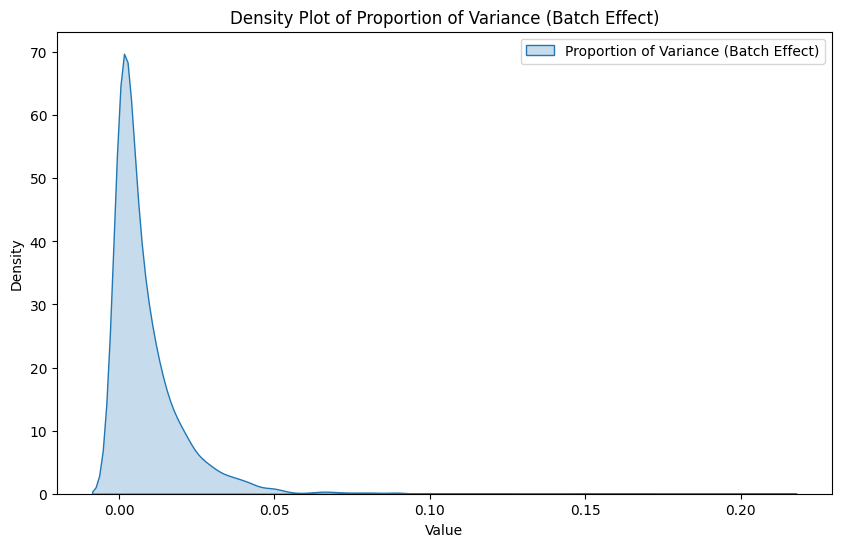

In [7]:
plt.figure(figsize=(10, 6))

# Density plot for 'Proportion of Variance (Batch Effect)'
sns.kdeplot(factor_attributes['Proportion of Variance (Batch Effect)'], label='Proportion of Variance (Batch Effect)', fill=True)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Proportion of Variance (Batch Effect)')
plt.legend()
plt.show()

/c4/home/sanjayr/.conda/envs/spectra_kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


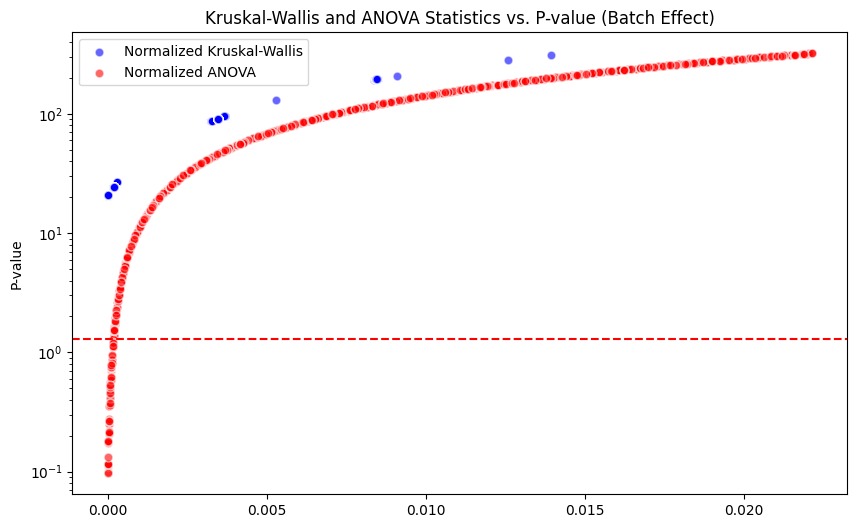

In [8]:
# Normalize the statistic values
anova_statistic_normalized = (factor_attributes['ANOVA statistic (Batch Effect)'] - factor_attributes['ANOVA statistic (Batch Effect)'].min()) / (factor_attributes['ANOVA statistic (Batch Effect)'].max() - factor_attributes['ANOVA statistic (Batch Effect)'].min())
kruskal_statistic_normalized = (factor_attributes['Kruskal-Wallis statistic (Batch Effect)'] - factor_attributes['Kruskal-Wallis statistic (Batch Effect)'].min()) / (factor_attributes['Kruskal-Wallis statistic (Batch Effect)'].max() - factor_attributes['Kruskal-Wallis statistic (Batch Effect)'].min())

plt.figure(figsize=(10, 6))

# Scatter plot for 'Kruskal-Wallis statistic (Batch Effect)'
plt.scatter(kruskal_statistic_normalized, 
            -np.log10(factor_attributes['Kruskal-Wallis Pval (Batch Effect)']), 
            color='blue', label='Normalized Kruskal-Wallis', alpha=0.6, edgecolor='w', s=40)

plt.scatter(anova_statistic_normalized, 
            -np.log10(factor_attributes['ANOVA Pval (Batch Effect)']), 
            color='red', label='Normalized ANOVA', alpha=0.6, edgecolor='w', s=40)

plt.axhline(-np.log10(0.05), color='red', linestyle='--')
plt.yscale('log')
plt.ylabel('P-value')
plt.title('Kruskal-Wallis and ANOVA Statistics vs. P-value (Batch Effect)')
plt.legend()
plt.show()

# Run Linear Regression on Cell x Factor to find Predictive factors

In [9]:
#individual cell scores
individual_cell_scores = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'], columns=adata.uns['SPECTRA_overlap'].index)
individual_cell_scores['individual'] = adata.obs['individual'].astype(str).to_numpy()

#Add labels model could be trained on
individual_cell_scores['disease_group'] = adata.obs['disease_group'].map({0: 'HC', 1: 'CL', 2: 'SSC'}).astype(str).to_numpy()
individual_cell_scores['sample_type'] = adata.obs['sample_type'].astype(str).to_numpy()
individual_cell_scores['cell_type'] = adata.obs['combined_annotation'].astype(str).to_numpy()


In [10]:
individual_cell_scores['disease_group']

0          CL
1          CL
2          CL
3          CL
4          CL
         ... 
261285    SSC
261286    SSC
261287     HC
261288    SSC
261289    SSC
Name: disease_group, Length: 261290, dtype: object

In [ ]:

comparisons = [
    ('CL_A', 'HC1'),
    ('CL_UA', 'HC1'),
    ('SSC_A', 'HC1'),
    ('SSC_UA', 'HC2')
]

#Subset to only CL samples
cl_mask = individual_cell_scores['disease_group'].isin(['CL'])
sample_mask = individual_cell_scores['sample_type'].isin(['A', 'UA'])

ct_cell_scores = {}
for cell_type in individual_cell_scores['cell_type'].unique():
    # Create a mask for the current cell type
    cell_type_mask = individual_cell_scores['cell_type'] == cell_type
    
    # Apply the masks to filter the DataFrame
    subset_cell_scores = individual_cell_scores[cell_type_mask & cl_mask & sample_mask]
    subset_cell_scores = subset_cell_scores.drop(columns = ['cell_type'])
    
    # Group by individual and disease group, then calculate mean scores
    subset_cell_scores = subset_cell_scores.groupby(['individual', 'disease_group', 'sample_type']).mean().reset_index()
    
    # Drop unnecessary columns
    subset_cell_scores = subset_cell_scores.drop(columns=['individual', 'disease_group'])
    
    # Store the result in the dictionary
    ct_cell_scores[cell_type] = subset_cell_scores


models = defaultdict(dict)

#Train ElasticNet for feature selection on cell scores to predict CL A vs UA for each cell type
for cell_type, cl_cell_scores in ct_cell_scores.items():
    cl_X = cl_cell_scores.drop(columns=['sample_type'])
    cl_y = cl_cell_scores['sample_type'].map({'A': 1, 'UA': 0}).to_numpy()
    cl_X_train, cl_X_test, cl_y_train, cl_y_test = train_test_split(cl_X, cl_y, test_size=0.2, random_state=42)

    #Lasso regression
    cl_lasso = Lasso(alpha=0.01)
    cl_lasso.fit(cl_X_train, cl_y_train)
    cl_lasso_pred = cl_lasso.predict(cl_X_test)
    lasso_mse = mean_squared_error(cl_y_test, cl_lasso_pred)


    #Elastic Net
    cl_elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.1)
    cl_elastic_net.fit(cl_X_train, cl_y_train)
    cl_en_pred = cl_elastic_net.predict(cl_X_test)
    en_mse = mean_squared_error(cl_y_test, cl_en_pred)

    # Store the models in the dictionary
    models[cell_type] = {
        'lasso': cl_lasso,
        'elastic_net': cl_elastic_net
    }

#They both return the same MSE...strange. Let's look at top factors for both
# ridge_coef = pd.Series(cl_ridge.coef_, index=cl_X.columns)
# ridge_coef = ridge_coef[ridge_coef != 0].sort_values(ascending=False)
# lasso_coef = pd.Series(cl_lasso.coef_, index=cl_X.columns)
# lasso_coef = lasso_coef[lasso_coef != 0].sort_values(ascending=False)
# en_coef = pd.Series(cl_elastic_net.coef_, index=cl_X.columns)
# en_coef = en_coef[en_coef != 0].sort_values(ascending=False)

# for alpha in [0.01, 0.1, 1.0]:
#     for l1_ratio in [0.1, 0.5, 0.9]:
#         cl_elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
#         scores = cross_val_score(cl_elastic_net, cl_X, cl_y, cv=5, scoring='neg_mean_squared_error')
#         print(f'Elastic Net (alpha={alpha}, l1_ratio={l1_ratio}) CV MSE: {-np.mean(scores)}')

Keratinocytes CL Ridge MSE: 0.1996676893472631
Keratinocytes CL Ridge Coefficients: [ 0.00129553  0.00305277 -0.0768597  ...  0.          0.
  0.        ]
Keratinocytes CL Lasso MSE: 0.2529884381736233
Keratinocytes CL Lasso Coefficients: [-0.  0. -0. ...  0.  0.  0.]
Keratinocytes Elastic Net MSE: 0.25265701510731536
Keratinocytes Elastic Net Coefficients: [-0.  0. -0. ...  0.  0.  0.]
Endothelial Cells CL Ridge MSE: 0.2126486309039787
Endothelial Cells CL Ridge Coefficients: [-0.00107034 -0.00511508  0.04610337 ...  0.          0.
  0.        ]
Endothelial Cells CL Lasso MSE: 0.2529884381736233
Endothelial Cells CL Lasso Coefficients: [-0. -0.  0. ...  0.  0.  0.]
Endothelial Cells Elastic Net MSE: 0.2528468969959251
Endothelial Cells Elastic Net Coefficients: [-0. -0.  0. ...  0.  0.  0.]
CD4_T CL Ridge MSE: 0.2565198610425447
CD4_T CL Ridge Coefficients: [-0.00225152 -0.00335323 -0.02687092 ...  0.          0.
  0.        ]
CD4_T CL Lasso MSE: 0.2529884381736233
CD4_T CL Lasso Coef

In [387]:
#Lasso and Elastic seem to push everything to 0
ridge_coef[:20]

1230-X-Keratinocytes-X-all_cholesterol-homeostasis      0.756950
1100-X-Keratinocytes-X-1100                             0.744672
16-X-global-X-all_iron-uptake-and-storage               0.742880
106-X-global-X-all_MHC-I-presentation                   0.600670
184-X-global-X-184                                      0.481668
397-X-CD4_T-X-397                                       0.466167
47-X-global-X-all_type-I-ifn-response                   0.449332
1190-X-Keratinocytes-X-all_oxidative-phosphorylation    0.445874
1166-X-Keratinocytes-X-1166                             0.430442
811-X-Endothelial Cells-X-all_MHC-I-presentation        0.428939
948-X-Fibroblasts-X-948                                 0.404534
1778-X-Smooth Muscle Cells-X-1778                       0.402533
1181-X-Keratinocytes-X-1181                             0.402313
1035-X-Fibroblasts-X-1035                               0.379501
175-X-global-X-all_MHC-I-presentation                   0.360182
1129-X-Keratinocytes-X-al

In [391]:
#Trying Random Forest
from sklearn.ensemble import RandomForestClassifier

cl_rf = RandomForestClassifier(n_estimators=100, random_state=42)
cl_rf.fit(cl_X_train, cl_y_train)
cl_rf_pred = cl_rf.predict(cl_X_test)
rf_mse = mean_squared_error(cl_y_test, cl_rf_pred)
print(f'Random Forest MSE: {rf_mse}')
rf_importances = cl_rf.feature_importances_
rf_importances = pd.Series(rf_importances, index=cl_X.columns)
rf_importances = rf_importances[rf_importances != 0].sort_values(ascending=False)

Random Forest MSE: 0.14285714285714285


In [393]:
rf_importances[:20]

1234-X-Keratinocytes-X-1234               0.018706
1197-X-Keratinocytes-X-1197               0.017013
1547-X-Melanocytes-X-1547                 0.015108
834-X-Endothelial Cells-X-834             0.014789
1995-X-Treg-X-1995                        0.014615
585-X-CD8_T-X-585                         0.014526
391-X-CD4_T-X-all_DNA-methylation         0.014520
592-X-CD8_T-X-592                         0.014404
1086-X-Keratinocytes-X-1086               0.013788
1990-X-Treg-X-1990                        0.013637
1978-X-Treg-X-1978                        0.013440
1251-X-Keratinocytes-X-1251               0.012019
1647-X-NK-X-TNK_cytotoxicity-effectors    0.011981
2043-X-Treg-X-2043                        0.011406
1130-X-Keratinocytes-X-1130               0.011097
2045-X-Treg-X-2045                        0.011090
1612-X-NK-X-1612                          0.010889
1428-X-Melanocytes-X-1428                 0.010464
289-X-B_memory-X-289                      0.010000
1596-X-NK-X-1596               

In [395]:
#Check if any of the factors are shared between the two classifiers
shared_factors = set(ridge_coef.index[:100]).intersection(set(rf_importances.index[:100]))
print(f'Shared factors: {shared_factors}')

Shared factors: {'391-X-CD4_T-X-all_DNA-methylation'}


# Wilcoxon T test on different sample types

In [11]:
# Sample 4 factors for each cell type, and include their cell_type and population size
# sample_factors = pd.DataFrame({'factor': factor_attributes.groupby('cell_type', group_keys=False).apply(lambda x: x.sample(4, random_state=42)).index})

#Reran this with all factors
sample_factors = pd.DataFrame({'factor': factor_attributes.index})
sample_factors['factor_idx'] = sample_factors['factor'].apply(lambda x: x.split('-X-')[0])
sample_factors['cell_type'] = sample_factors['factor'].apply(lambda x: x.split('-X-')[1])
sample_factors['population_size'] = (sample_factors['cell_type'].map(adata.obs['combined_annotation'].value_counts()))
sample_factors.loc[sample_factors['cell_type'] == 'global', 'population_size'] = len(adata.obs)

In [12]:
#Run a Wilcoxon comparing the means of a factor's cell scores across different sample types
def run_wilcoxon(adata, factor_idx, ct):
    cell_scores = adata.obsm['SPECTRA_cell_scores']

    #Only choose cell type if mask, since that is the celltype for this factor
    if ct != 'global':
        # ct = factor_attributes['cell_type'].iloc[factor_idx]
        ct_mask = [cell_type == ct for cell_type in adata.obs['combined_annotation']]
        ct_scores = cell_scores[ct_mask]
        
        factor_scores = ct_scores[:,factor_idx]
        cell_samples = adata.obs['d_sample_type'][ct_mask]
    else:
        factor_scores = cell_scores[:,factor_idx]
        cell_samples = adata.obs['d_sample_type']

    comparisons = [
        ('CL_A', 'HC1'),
        ('CL_UA', 'HC1'),
        ('SSC_A', 'HC1'),
        ('SSC_UA', 'HC2')
    ]

    results = {}

    for group1, group2 in comparisons:
        group1_scores = factor_scores[cell_samples == group1]
        group2_scores = factor_scores[cell_samples == group2]

        statistic, pval = stats.ranksums(group1_scores, group2_scores)
        results[(group1, group2)] = {
            'statistic': statistic,
            'pval': pval
        }
    
    return results

In [13]:
# Define the comparisons
comparisons = [
    ('CL_A', 'HC1'),
    ('CL_UA', 'HC1'),
    ('SSC_A', 'HC1'),
    ('SSC_UA', 'HC2')
]

# Run the Wilcoxon test for each factor and cell type, and store the results
results_list = []

for idx, row in sample_factors.iterrows():
    factor_idx = int(row['factor_idx'])
    cell_type = row['cell_type']

    #Test for each cell type if global
    if cell_type == 'global':
        for ct in sample_factors['cell_type'].unique():
            results = run_wilcoxon(adata, factor_idx, ct)
            result_row = {'factor_idx': factor_idx, 'cell_type_compared': ct}
            for (group1, group2), result in results.items():
                # result_row[f'{group1} vs {group2}, statistic'] = result['statistic']
                result_row[f'{group1} vs {group2}, pval'] = result['pval']
                
            results_list.append(result_row)

    #Otherwise just test for the specific cell type
    else:
        results = run_wilcoxon(adata, factor_idx, cell_type)
        
        result_row = {'factor_idx': factor_idx, 'cell_type_compared': cell_type}
        for (group1, group2), result in results.items():
            # result_row[f'{group1} vs {group2}, statistic'] = result['statistic']
            result_row[f'{group1} vs {group2}, pval'] = result['pval']
        
        results_list.append(result_row)

# Create a DataFrame from the results list
batch_df = pd.DataFrame(results_list)

for (group1, group2), result in results.items():
    # result_row[f'{group1} vs {group2}, statistic'] = result['statistic']
    _, corrected_p_vals, _, _ = multipletests(batch_df[f'{group1} vs {group2}, pval'], method='fdr_bh')
    batch_df[f'{group1} vs {group2}, pval adjusted (FDR)'] = corrected_p_vals

# Set the index to be factor + cell type
sample_factors['factor_idx'] = sample_factors['factor_idx'].astype(int)
batch_df['factor_idx'] = batch_df['factor_idx'].astype(int)

batch_comparison_df = batch_df.merge(sample_factors, on='factor_idx', how='left')
batch_comparison_df.to_csv('factor_batch_assoc.csv')

# Run From Here

In [9]:
batch_comparison_df = pd.read_csv('factor_batch_assoc.csv').drop(columns=['Unnamed: 0'])
batch_comparison_df

,factor_idx,cell_type_compared,"CL_A vs HC1, pval","CL_UA vs HC1, pval","SSC_A vs HC1, pval","SSC_UA vs HC2, pval","CL_A vs HC1, pval adjusted (FDR)","CL_UA vs HC1, pval adjusted (FDR)","SSC_A vs HC1, pval adjusted (FDR)","SSC_UA vs HC2, pval adjusted (FDR)",factor,cell_type,population_size
0,0,global,0.762372,0.000007,0.004341,0.000001,0.808059,0.000024,0.010213,0.000006,0-X-global-X-all_chondroitine-and-heparan-sulf...,global,261290.0
1,0,B_memory,0.428604,0.979225,0.795108,0.674364,0.507771,0.987876,0.849441,0.791960,0-X-global-X-all_chondroitine-and-heparan-sulf...,global,261290.0
2,0,CD4_T,0.306981,0.155024,0.009101,0.084557,0.384036,0.266823,0.019904,0.173440,0-X-global-X-all_chondroitine-and-heparan-sulf...,global,261290.0
3,0,CD8_T,0.377210,0.168774,0.295176,0.669382,0.455618,0.284907,0.407398,0.788400,0-X-global-X-all_chondroitine-and-heparan-sulf...,global,261290.0
4,0,DC,0.345119,0.158688,0.639651,0.142353,0.423683,0.271615,0.726191,0.260642,0-X-global-X-all_chondroitine-and-heparan-sulf...,global,261290.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5248,2098,pDC,0.599632,0.688500,0.284066,0.587594,0.668869,0.802460,0.395076,0.724051,2098-X-pDC-X-2098,pDC,292.0
5249,2099,pDC,0.154913,0.349575,0.264074,0.328972,0.212692,0.498728,0.373702,0.485282,2099-X-pDC-X-CD8-T_terminal-exhaustion,pDC,292.0
5250,2100,pDC,0.018871,0.592980,0.909269,0.103742,0.032522,0.729195,0.934531,0.203417,2100-X-pDC-X-all_TNF-via-NFkB_signaling,pDC,292.0
5251,2101,pDC,0.041025,0.285049,0.698411,0.913627,0.065864,0.430027,0.772181,0.943997,2101-X-pDC-X-2101,pDC,292.0


In [20]:
batch_comparison_df[batch_comparison_df['CL_A vs HC1, pval adjusted (FDR)'] < 0.05].sort_values('CL_A vs HC1, pval', ascending=True)['factor_idx'].nunique()

1526

In [ ]:
#Which ones have the most association

#pick a comparison to start w, sort by statistics + adjusted pval (keep original + adjusted for all comparisons), drop statistic, # significant factors per comparison, sort by unique factors, annotations(?)
#Add a column that is HC1 vs HC2 (negative control for significance)
# Look for overlap between different cases (CL_A vs HC1 + SSC_A vs HC1), how it breaks down by cell type of factor

In [6]:
dseq_scores = pd.read_csv('/krummellab/data1/DSCoLab/AUTOIPI/papers/skin/data/DB3_54/harmony/liger/outputs/no_ribo_no_batch/sample_by_prog.csv')
dseq_scores

,sample,B Cells.R15_Program1,B Cells.R15_Program2,B Cells.R15_Program3,B Cells.R15_Program4,B Cells.R15_Program7,B Cells.R15_Program8,B Cells.R15_Program10,B Cells.R15_Program12,B Cells.R15_Program13,...,Keratinocytes.R25_Program16,Keratinocytes.R25_Program17,Keratinocytes.R25_Program18,Keratinocytes.R25_Program19,Keratinocytes.R25_Program20,Keratinocytes.R25_Program21,Keratinocytes.R25_Program22,Keratinocytes.R25_Program23,Keratinocytes.R25_Program24,Keratinocytes.R25_Program25
0,AIP1-SLE17-E1TPA1,3.869091,4.760355,2.193738,0.880415,3.795552,0.768691,2.112006,2.435336,8.006351,...,7.105296,1.443389,2.019341,1.883130,4.162882,2.763755,3.197803,0.624887,0.256111,1.410379
1,AIP1-SLE30-E1TPB1,6.534493,1.895659,2.836032,0.372295,2.911344,0.397405,2.126386,5.044211,3.466211,...,0.948370,1.037673,1.508276,0.960646,2.428214,4.020781,2.266702,0.672164,0.748372,1.649598
2,AIP1-SLE23-E1TPA1,0.650657,1.335579,4.901891,0.000000,8.655030,0.552405,2.163707,2.514963,0.000000,...,5.023156,1.622552,1.255692,1.359681,2.589735,2.473096,2.238252,0.546453,0.385193,1.872617
3,AIP1-SLE30-E1TPA1,4.983539,2.175375,4.262262,0.532934,3.024485,0.623117,1.795387,5.710622,2.663230,...,6.961148,0.564403,0.833724,1.511712,2.283956,2.542937,3.116051,0.889762,0.272292,0.846018
4,AIP1-SLE17-E1TPB1,2.088807,2.964123,4.252795,0.000000,2.325789,6.001403,1.750225,2.699320,1.089681,...,4.467638,1.642090,0.840139,3.483392,2.577038,3.481644,2.644427,0.672129,0.297083,0.783262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,AIP1-SSC151-E1TPB1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.414516,0.609020,0.232877,1.062010,4.017185,1.119021,3.082353,0.715212,0.217873,1.272558
78,AIP1-SSC151-E1TPA1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.267685,0.654855,0.697167,2.711711,3.471198,0.483854,8.269274,0.378957,0.229611,0.755905
79,AIP1-SSC177-E1TPB1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.191637,0.332509,0.425071,0.292702,3.828743,0.832438,2.278356,0.527830,0.365840,0.759066
80,AIP1-SSC177-E1TPA1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.205463,1.046877,1.198343,0.874001,3.788458,0.960870,3.662219,0.284090,0.162978,1.194729


In [ ]:
adata

AnnData object with n_obs × n_vars = 261290 × 28683
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'doubletFinderScore', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'percent.ribo', 'isotype_ctl_max', 'S.Score', 'G2M.Score', 'Phase', 'pool', 'batch', 'biospecimen', 'individual', 'subtype', 'disease_group', 'years_since_diagnosis', 'Age', 'Sex at Birth', 'sample_type', 'd_sample_type', 'location', 'cluster_label', 'spectra_annotation', 'combined_annotation'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'spectra_vocab'
    uns: 'SPECTRA_factors', 'SPECTRA_markers', 'SPECTRA_L', 'SPECTRA_overlap'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'SPECTRA_cell_scores'
    varm: 'HARMONY', 'PCs'

In [25]:
cell_scores = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'], columns=adata.uns['SPECTRA_overlap'].index)
cell_scores['sample'] = adata.obs['biospecimen'].to_numpy()
cell_scores = cell_scores.groupby('sample', as_index=False).mean()
cell_scores.to_csv('SPECTRA_cell_scores.csv')

In [26]:
cell_scores

,sample,0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis,1-X-global-X-all_retinol_metabolism,2-X-global-X-all_RIG-I-like-receptor_signaling,3-X-global-X-all_propanoate_metabolism,4-X-global-X-all_p53-signaling,5-X-global-X-all_reticulophagy,6-X-global-X-all_circadian-rhythm,7-X-global-X-all_VAL-LEU-ILE_metabolism,8-X-global-X-all_taurine-hypotaurine_metabolism,...,2093-X-pDC-X-DC_antigen-crosspresentation,2094-X-pDC-X-2094,2095-X-pDC-X-2095,2096-X-pDC-X-all_TNF-via-NFkB_signaling,2097-X-pDC-X-all_MHC-I-presentation,2098-X-pDC-X-2098,2099-X-pDC-X-CD8-T_terminal-exhaustion,2100-X-pDC-X-all_TNF-via-NFkB_signaling,2101-X-pDC-X-2101,2102-X-pDC-X-2102
0,AIP1-SLE108-E1TPA1,0.000041,0.000026,0.000465,0.000173,0.000445,0.000050,0.000277,0.000043,0.000247,...,9.530921e-11,2.272054e-15,1.013449e-15,4.858686e-11,1.760816e-14,7.287849e-07,1.075680e-13,1.806811e-12,4.275754e-07,1.243412e-07
1,AIP1-SLE108-E1TPB1,0.000057,0.000044,0.000697,0.000310,0.000807,0.000083,0.000465,0.000075,0.000427,...,6.267916e-14,6.821890e-10,3.909355e-11,2.064703e-14,3.204305e-13,5.519255e-08,1.402324e-10,1.698256e-15,5.354053e-07,1.710135e-07
2,AIP1-SLE113-E1TPA1,0.000043,0.000035,0.000661,0.000222,0.000649,0.000101,0.000458,0.000068,0.000298,...,2.912835e-04,2.276142e-08,3.689785e-04,2.002363e-05,3.053995e-05,2.900616e-04,8.200632e-06,1.385418e-06,1.050093e-05,3.345606e-04
3,AIP1-SLE113-E1TPB1,0.000038,0.000027,0.000432,0.000178,0.000535,0.000061,0.000456,0.000048,0.000270,...,4.108658e-10,9.841269e-15,3.027215e-06,4.745697e-16,6.616468e-13,2.251823e-06,4.686998e-07,5.876411e-17,1.317946e-07,2.772774e-06
4,AIP1-SLE114-E1TPA1,0.000050,0.000050,0.000357,0.000374,0.000648,0.000076,0.000580,0.000085,0.000419,...,5.247175e-06,2.083022e-16,2.418413e-06,9.722049e-12,2.280201e-06,6.223488e-11,4.884357e-10,3.017646e-17,9.851345e-15,7.055211e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,AIP1-SSC91-E1TPB1,0.000037,0.000029,0.000500,0.000284,0.000606,0.000052,0.000441,0.000061,0.000253,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
78,AIP1-SSC92-E1TPA1,0.000045,0.000051,0.000748,0.000709,0.000805,0.000069,0.000429,0.000069,0.000347,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
79,AIP1-SSC92-E1TPB1,0.000038,0.000037,0.000554,0.000547,0.001075,0.000070,0.000468,0.000066,0.000286,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
80,AIP1-SSC94-E1TPA1,0.000052,0.000047,0.000544,0.000192,0.000795,0.000037,0.000503,0.000087,0.000353,...,6.430978e-11,2.914681e-16,4.454500e-07,1.565514e-15,1.732720e-13,3.486448e-07,1.029511e-06,8.045059e-11,1.276195e-06,1.011509e-06


# Visualizing factors by cell type

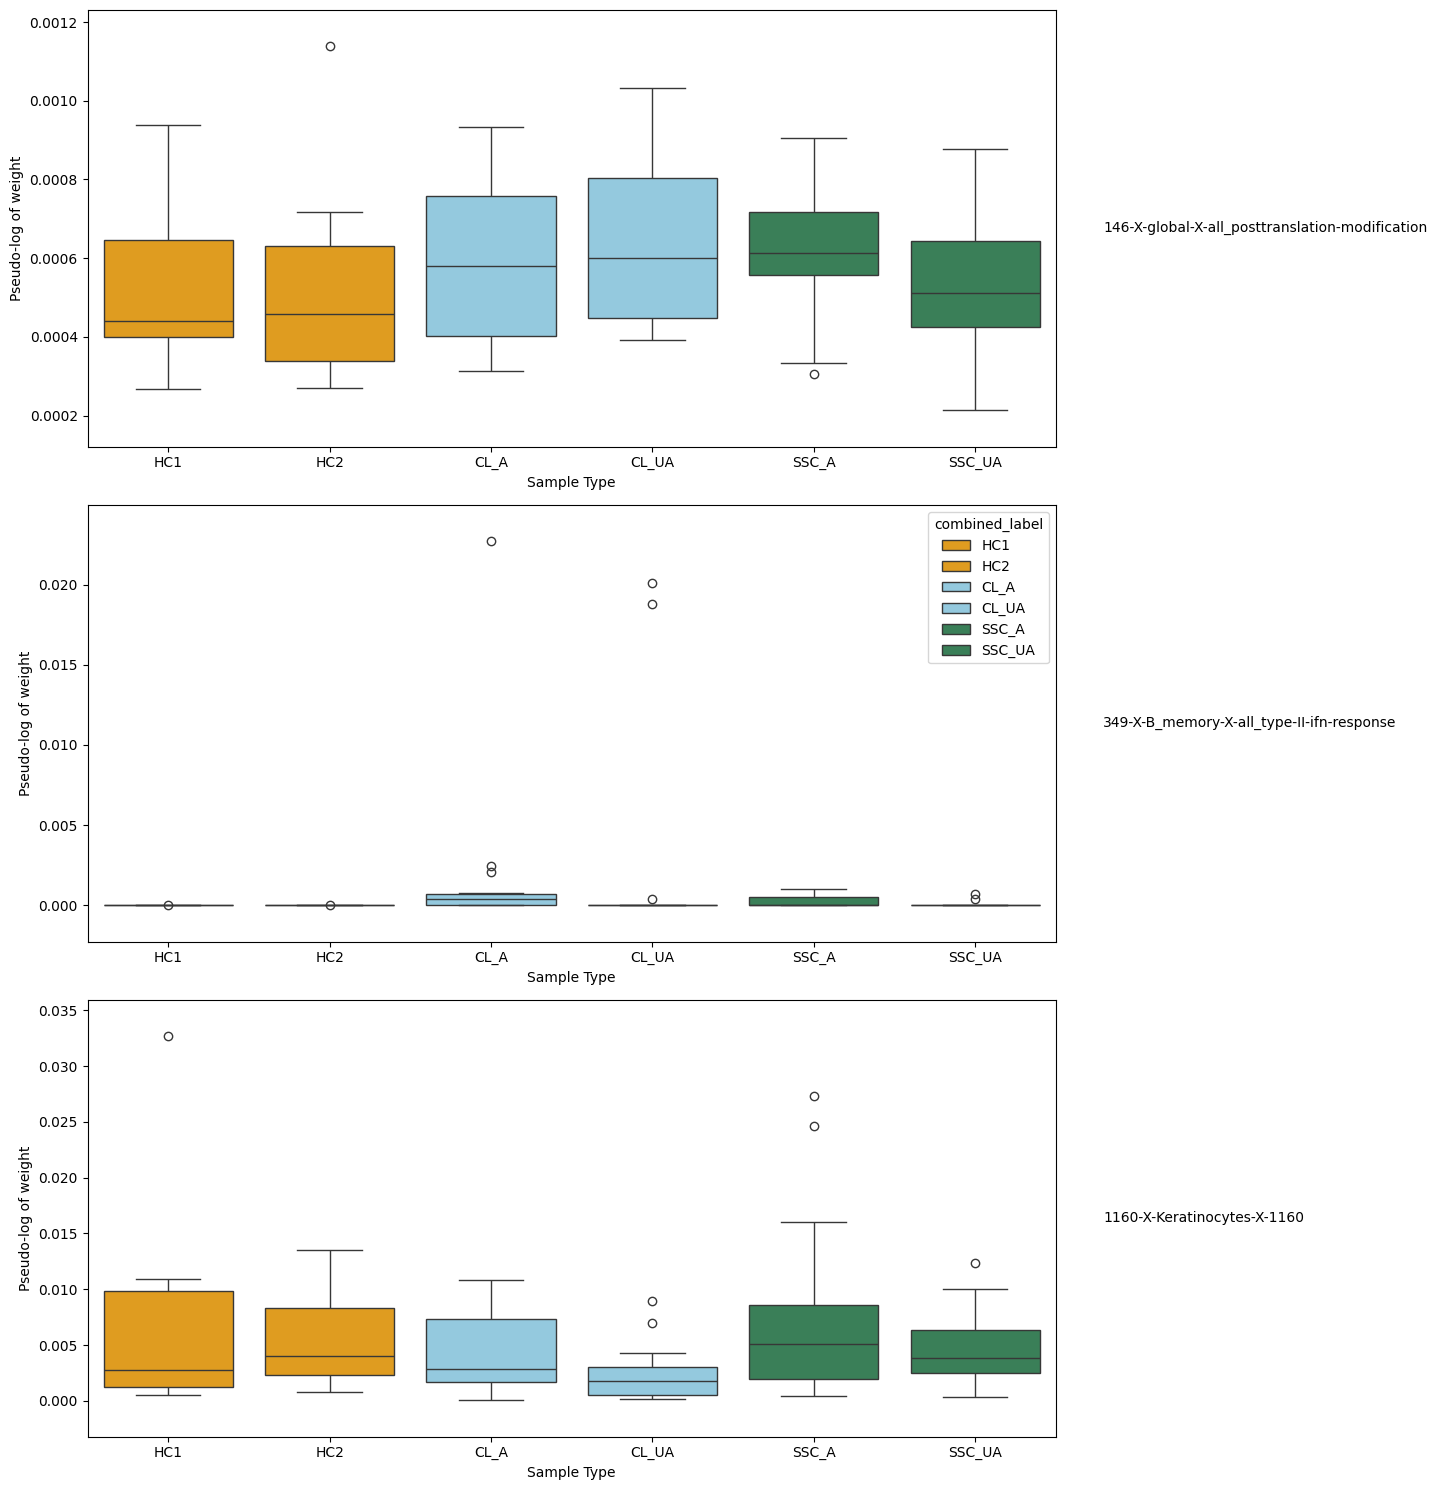

In [271]:
def plot_multiple_factors_grid(adata, factor_indices, description=None, global_ct=None, n_cols=1):
    n_factors = len(factor_indices)
    n_rows = (n_factors + n_cols - 1) // n_cols  # Calculate number of rows needed
    
    # Create figure with appropriate height based on number of rows
    fig = plt.figure(figsize=(15, 5 * n_rows))
    gs = GridSpec(n_rows, n_cols + 1, width_ratios=[3] * n_cols + [1])  # Add extra column for annotations
    
    # Define sample type order and colors
    sample_order = ['HC1', 'HC2', 'CL_A', 'CL_UA', 'SSC_A', 'SSC_UA']
    disease_colors = {'HC': 'orange', 'CL': 'skyblue', 'SSC': 'seagreen'}

    # Create a color palette mapping for combined labels
    color_palette = {}
    for label in sample_order:
        if '_' in label:
            disease = label.split('_')[0]
            color_palette[label] = disease_colors[disease]
        else:
            color_palette[label] = disease_colors['HC']
    
    for i, factor_idx in enumerate(factor_indices):
        row = i // n_cols
        col = i % n_cols
        
        # Create main plot for this factor
        ax = fig.add_subplot(gs[row, col])
        
        # Extract cell scores and sample types
        cell_scores = np.log1p(adata.obsm['SPECTRA_cell_scores'][:, factor_idx])  # Pseudo-log transform
        disease_groups = adata.obs['disease_group'].map({0: 'HC', 1: 'CL', 2: 'SSC'})
        sample_types = adata.obs['sample_type']

        #Data for splitting by cell type
        ct = factor_attributes['cell_type'].iloc[factor_idx]
        ct_mask = [cell_type == ct for cell_type in adata.obs['combined_annotation']] 

        #Allow for cell type specific view of cell scores for global factors
        if global_ct and ct == 'global':
            ct_mask = [cell_type == global_ct for cell_type in adata.obs['combined_annotation']]


        #Only choose cell type if mask, since that is the celltype for this factor
        if ct != 'global' or (global_ct and ct == 'global'):
            cell_scores = cell_scores[ct_mask]
            disease_groups = disease_groups[ct_mask]
            sample_types = sample_types[ct_mask]
        

        # Create combined labels for disease group and sample type
        combined_labels = []
        for dg, st in zip(disease_groups, sample_types):
            if dg == 'HC':
                combined_labels.append(st)  # HC1 or HC2
            else:
                combined_labels.append(f"{dg}_{st}")  # CL_A, CL_UA, SSC_A, SSC_UA
        
        # Create a DataFrame for plotting
        plot_data = pd.DataFrame({
            'weight': cell_scores,
            # 'disease_group': disease_groups,
            # 'sample_type': sample_types,
            'combined_label': combined_labels
        })

        #Group cell scores per individual
        if ct != 'global' or (global_ct and ct == 'global'):
            plot_data['individual'] = adata.obs['individual'][ct_mask].astype(str).to_numpy()
        else:
            plot_data['individual'] = adata.obs['individual'].astype(str).to_numpy()
            
        plot_data = plot_data.groupby(['individual', 'combined_label']).mean().reset_index()

        #Add the other columns back again (removed for sake of groupby)
        plot_data['disease_group'] = plot_data['combined_label'].apply(lambda x: x.split('_')[0] if '_' in x else 'HC')
        plot_data['sample_type'] = plot_data['combined_label'].apply(lambda x: x.split('_')[1] if '_' in x else x)
        
        # Plot the boxplot
        show_legend = (i==1)
        boxplot = sns.boxplot(
            x='combined_label', 
            y='weight',
            hue='combined_label',  # Set hue to the same as x
            data=plot_data,
            order=sample_order,
            hue_order=sample_order,
            palette=color_palette,  # Use the color mapping
            legend=show_legend,
            ax=ax
        )
        
        # Customize the plot
        ax.set_xlabel('Sample Type')
        
        # Only show y-label for the leftmost plots
        if col == 0:
            ax.set_ylabel('Pseudo-log of weight')
        else:
            ax.set_ylabel('')
            
        # Set y-limits based on the data range with some padding
        y_min, y_max = plot_data['weight'].min(), plot_data['weight'].max()
        padding = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - padding, y_max + padding)
        
        # Add annotation panel for this factor
        ax_annot = fig.add_subplot(gs[row, n_cols])
        ax_annot.axis('off')
        
        # Add cell type and marker genes information if provided
        if description.any() and len(description) > i:
            factor_name = description[i]
            ax_annot.text(0.1, 0.5, 
                         f"{factor_name}", 
                         fontsize=10, 
                         verticalalignment='center', 
                         wrap=True)
        else:
            ax_annot.text(0.1, 0.5, 
                         f"Factor {factor_idx}", 
                         fontsize=10, 
                         verticalalignment='center')
        
        # Set background color for annotation panel
        ax_annot.set_facecolor('lightgrey')
    
    plt.tight_layout()
    return fig

# Example usage:
factor_indices = [146, 349, 1160]
fig = plot_multiple_factors_grid(adata, factor_indices, factor_attributes.index[factor_indices], n_cols=1)
plt.show()

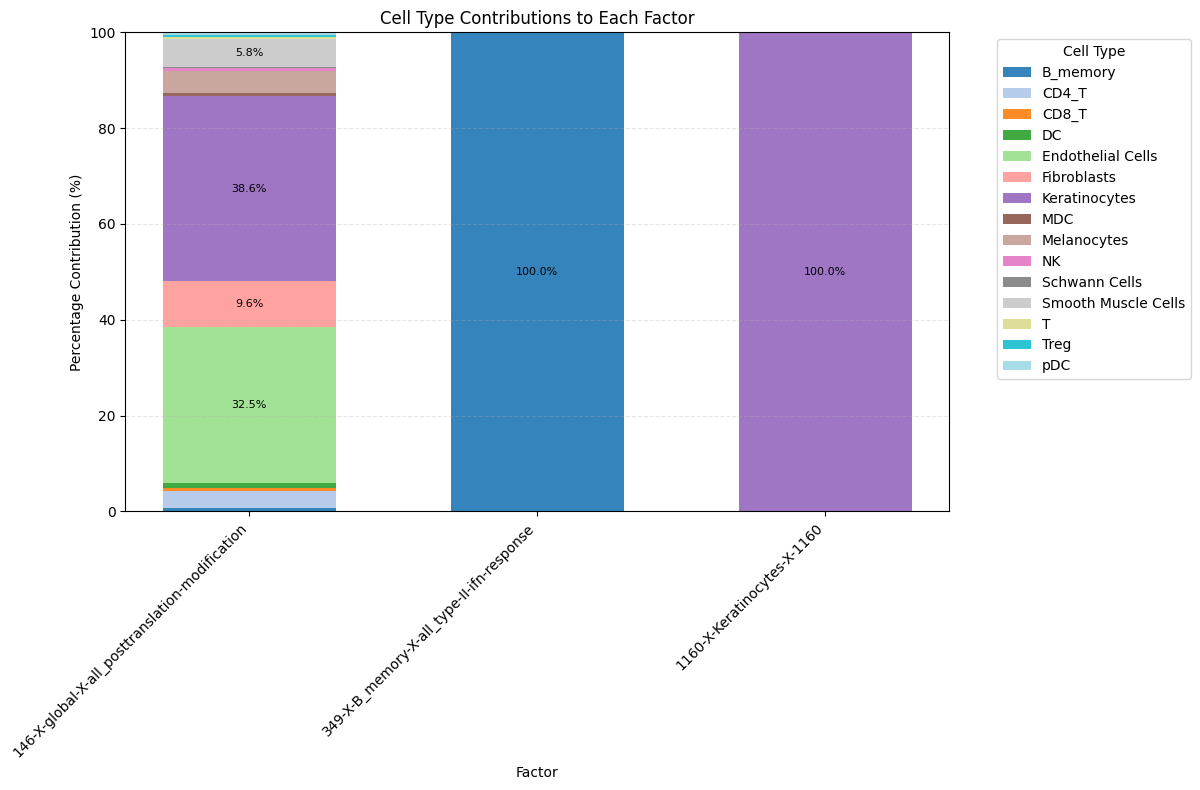

In [266]:
def plot_factor_barplots(adata, factor_indices, factor_titles, figsize=(12, 8)):
    # Extract cell scores and cell types
    cell_scores = adata.obsm['SPECTRA_cell_scores']
    cell_types = adata.obs['combined_annotation']
    
    # Get unique cell types
    unique_cell_types = np.unique(cell_types)
    num_cell_types = len(unique_cell_types)
    num_factors = len(factor_indices)
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Set width of bars and positions
    bar_width = 0.6
    positions = np.arange(num_factors)

    # Create a colormap for different cell types
    colors = plt.cm.tab20(np.linspace(0, 1, num_cell_types))

    all_percentages = []

    # Calculate mean scores for each cell type and factor
    for factor_idx in factor_indices:
        factor_percentages = []
        
        # Calculate total sum for this factor
        total_mask = cell_scores[:, factor_idx] != 0
        total_sum = np.sum(cell_scores[total_mask, factor_idx])
        
        for cell_type in unique_cell_types:
            # Select non-zero scores for the current cell type and factor
            mask = (cell_types == cell_type) & (cell_scores[:, factor_idx] != 0)
            scores = cell_scores[mask, factor_idx]
            
            # Calculate sum and percentage
            cell_sum = np.sum(scores) if len(scores) > 0 else 0
            percentage = (cell_sum / total_sum * 100) if total_sum > 0 else 0
            factor_percentages.append(percentage)
            
        all_percentages.append(factor_percentages)
    
    # Plot stacked bars
    bottom_values = np.zeros(num_factors)
    
    # Create legend handles for cell types
    legend_handles = []
    
    for cell_idx, cell_type in enumerate(unique_cell_types):
        # Get percentages for this cell type across all factors
        cell_percentages = [all_percentages[f_idx][cell_idx] for f_idx in range(num_factors)]
        
        # Plot bar segments for this cell type
        bar = plt.bar(positions, cell_percentages, bar_width, 
                      bottom=bottom_values, label=cell_type, 
                      color=colors[cell_idx], alpha=0.9)
        
        # Add to legend if this cell type has visible contribution
        if np.any(np.array(cell_percentages) > 1):
            legend_handles.append(bar)
        
        # Update bottoms for next cell type
        bottom_values += cell_percentages
        
        # Add percentage labels in segments
        for i in range(num_factors):
            if cell_percentages[i] >= 5:  # Only label segments that are large enough
                # Calculate y position for text (center of segment)
                y_pos = bottom_values[i] - cell_percentages[i]/2
                plt.text(positions[i], y_pos, f'{cell_percentages[i]:.1f}%', 
                         ha='center', va='center', fontsize=8, color='black')
    
    # Add labels and legend
    plt.xlabel('Factor')
    plt.ylabel('Percentage Contribution (%)')
    plt.title('Cell Type Contributions to Each Factor')
    plt.xticks(positions, factor_titles, rotation=45, ha='right')
    plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.show()

plot_factor_barplots(adata, factor_indices, factor_attributes.index[factor_indices])

# Cluster Factor scores, label by cell type

In [46]:
# Running PCA/UMAP on cell scores for each FACTOR, so we see how they group
pca = PCA(n_components=2)
pca_result = pca.fit_transform(adata.obsm['SPECTRA_cell_scores'].T)
factor_attributes['pca1'] = pca_result[:, 0]
factor_attributes['pca2'] = pca_result[:, 1]

reducer = umap.UMAP(n_components=2, random_state=29)
umap_result = reducer.fit_transform(adata.obsm['SPECTRA_cell_scores'].T)
factor_attributes['umap1'] = umap_result[:, 0]
factor_attributes['umap2'] = umap_result[:, 1]

/c4/home/sanjayr/.conda/envs/spectra_kernel/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


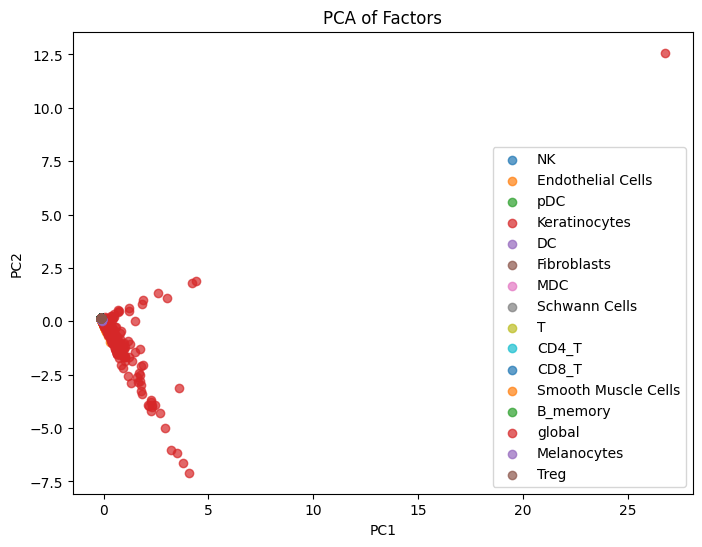

In [47]:
plt.figure(figsize=(8,6))
unique_labels = set(factor_attributes['cell_type'])

for label in unique_labels:
    idx = factor_attributes['cell_type'] == label
    plt.scatter(factor_attributes['pca1'][idx], factor_attributes['pca2'][idx], label=label, alpha=0.7)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Factors")
plt.legend()
plt.show()

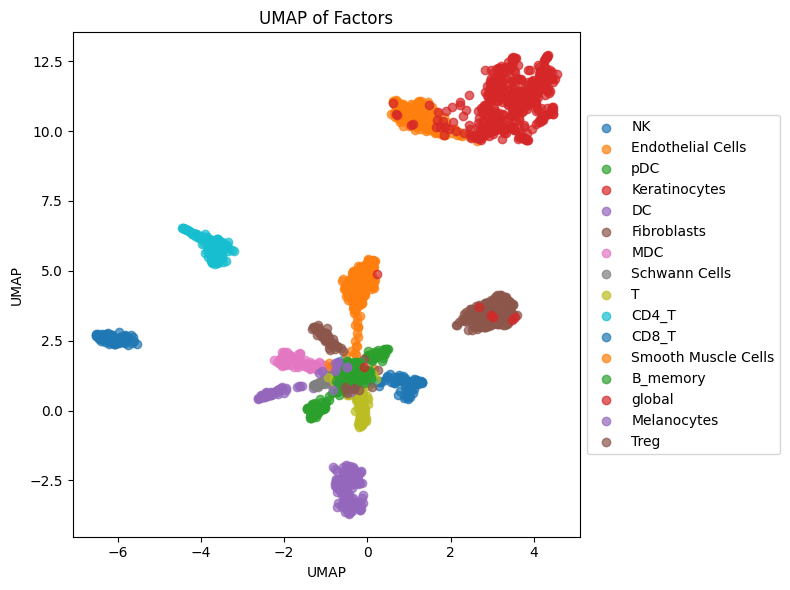

In [48]:
plt.figure(figsize=(8,6))
unique_labels = set(factor_attributes['cell_type'])

for label in unique_labels:
    idx = factor_attributes['cell_type'] == label
    plt.scatter(factor_attributes['umap1'][idx], factor_attributes['umap2'][idx], label=label, alpha=0.7)

plt.xlabel("UMAP")
plt.ylabel("UMAP")
plt.title("UMAP of Factors")
# Move legend to the side
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Adjust layout to fit the legend
plt.tight_layout()
plt.show()

## Creating UMAP and PCA for each cell with disease overlay

In [49]:
pca = PCA(n_components=2)
pca_result_cells = pca.fit_transform(adata.obsm['SPECTRA_cell_scores'])

reducer = umap.UMAP(n_components=2, random_state=29)
umap_result_cells = reducer.fit_transform(adata.obsm['SPECTRA_cell_scores'])

/c4/home/sanjayr/.conda/envs/spectra_kernel/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


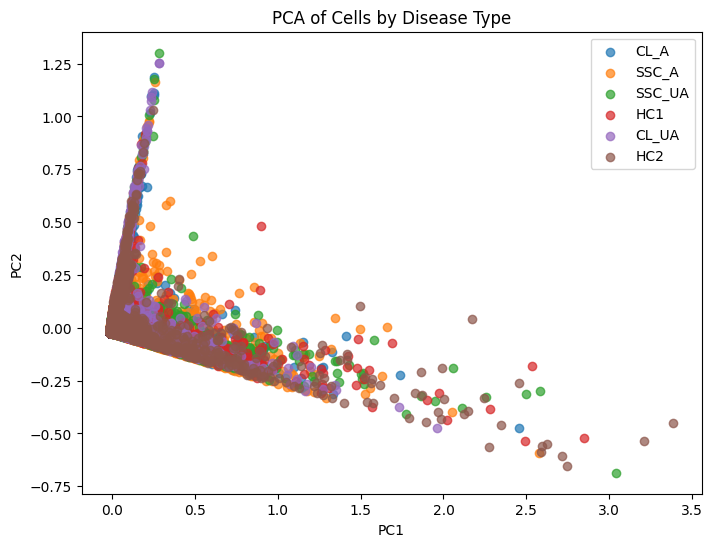

In [50]:
plt.figure(figsize=(8,6))
unique_labels = set(adata.obs['d_sample_type'])

for label in unique_labels:
    idx = adata.obs['d_sample_type'] == label
    plt.scatter(pca_result[:,0][idx], pca_result[:,1][idx], label=label, alpha=0.7)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Cells by Disease Type")
plt.legend()
plt.show()

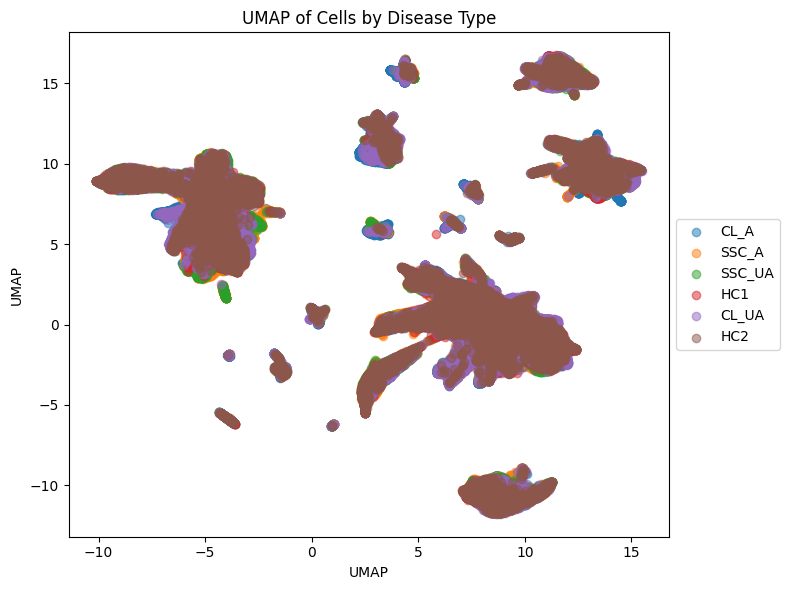

In [51]:
plt.figure(figsize=(8,6))
unique_labels = set(adata.obs['d_sample_type'])

for label in unique_labels:
    idx = adata.obs['d_sample_type'] == label
    plt.scatter(umap_result[:,0][idx], umap_result[:,1][idx], label=label, alpha=0.5)

plt.xlabel("UMAP")
plt.ylabel("UMAP")
plt.title("UMAP of Cells by Disease Type")
# Move legend to the side
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Adjust layout to fit the legend
plt.tight_layout()
plt.show()

# Run Batch comparisons of Decipher-Seq to compare

In [323]:
def batch_association_comparison(metadata, cell_scores):
    # Create masks based on batch to apply on cell_scores
    batch_labels = metadata['Batch']
    unique_batches = set(batch_labels)
    batch_masks = {batch: batch_labels == batch for batch in unique_batches}

    cell_scores = cell_scores.set_index('sample').fillna(0)

    num_factors = cell_scores.shape[1]

    statistics = np.zeros(num_factors)
    p_vals = np.zeros(num_factors)
    prop_variance = np.zeros(num_factors)
    
    k_statistics = np.zeros(num_factors)
    k_p_vals = np.zeros(num_factors)

    #Create dataframe to fit ANOVA OLS model
    df = pd.DataFrame({'factor_scores': np.zeros(cell_scores.shape[0]), 'batch': batch_labels})

    for factor_idx in range(num_factors):
        # Grab a single factor
        factor_scores = cell_scores.iloc[:, factor_idx].to_numpy()

        # Create DataFrame for statsmodels
        df['factor_scores'] = factor_scores

        # Running OLS-based ANOVA (dependent is factor scores, batch is the cateogrical variable)
        model = ols('factor_scores ~ C(batch)', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)

        # Extract F-statistic, p-value, and proportion of variance explained
        statistic = anova_table["F"].iloc[0]
        p_val = anova_table["PR(>F)"].iloc[0]
        prop_variance_explained = anova_table['sum_sq'].iloc[0] / anova_table['sum_sq'].sum()

        statistics[factor_idx] = statistic
        p_vals[factor_idx] = p_val
        prop_variance[factor_idx] = prop_variance_explained

        # Running Kruskal-Wallis H test (non-parametric ANOVA)
        batch_groups = [factor_scores[batch_masks[batch]] for batch in unique_batches]
        k_stats, k_p_pval = kruskal(*batch_groups)

        k_statistics[factor_idx] = k_stats
        k_p_vals[factor_idx] = k_p_pval

    # Correct p-values for multiple testing using Benjamini-Hochberg (FDR)
    _, corrected_p_vals, _, _ = multipletests(p_vals, method='fdr_bh')
    _, corrected_k_p_vals, _, _ = multipletests(k_p_vals, method='fdr_bh')

    return statistics, corrected_p_vals, prop_variance, k_statistics, corrected_k_p_vals

    # return statistics, p_vals, prop_variance, k_statistics, k_p_vals


dseq_meta_data = pd.read_csv('/krummellab/data1/DSCoLab/AUTOIPI/papers/skin/data/DB3_54/harmony/liger/outputs/no_ribo_no_batch/meta_sample.csv')
dseq_scores = pd.read_csv('/krummellab/data1/DSCoLab/AUTOIPI/papers/skin/data/DB3_54/harmony/liger/outputs/no_ribo_no_batch/sample_by_prog.csv')
anova_statistics, anova_pvals, prop_variance, kruskal_statistics, kruskal_p_vals = batch_association_comparison(dseq_meta_data, dseq_scores)

dseq_factor_attributes = pd.DataFrame(index=dseq_scores.columns[1:])
dseq_factor_attributes['ANOVA statistic (Batch Effect)'] = anova_statistics
dseq_factor_attributes['ANOVA Pval (Batch Effect)'] = anova_pvals
dseq_factor_attributes['Proportion of Variance (Batch Effect)'] = prop_variance
dseq_factor_attributes['Kruskal-Wallis statistic (Batch Effect)'] = kruskal_statistics
dseq_factor_attributes['Kruskal-Wallis Pval (Batch Effect)'] = kruskal_p_vals

In [324]:
dseq_factor_attributes.to_csv('dseq_factor_stats.csv')
dseq_factor_attributes

,ANOVA statistic (Batch Effect),ANOVA Pval (Batch Effect),Proportion of Variance (Batch Effect),Kruskal-Wallis statistic (Batch Effect),Kruskal-Wallis Pval (Batch Effect)
B Cells.R15_Program1,1.340115,2.748573e-01,0.158779,9.676213,5.033550e-01
B Cells.R15_Program2,0.378236,9.522158e-01,0.050578,3.616458,9.695463e-01
B Cells.R15_Program3,0.875889,5.956772e-01,0.109817,4.856983,9.255391e-01
B Cells.R15_Program4,0.799535,6.560496e-01,0.101213,4.013144,9.597213e-01
B Cells.R15_Program7,1.204940,3.474274e-01,0.145087,10.800953,4.153286e-01
...,...,...,...,...,...
Keratinocytes.R25_Program21,9.493566,5.305501e-09,0.572123,58.138407,1.004075e-07
Keratinocytes.R25_Program22,3.133751,4.905800e-03,0.306217,22.434837,2.074596e-02
Keratinocytes.R25_Program23,2.823305,9.581231e-03,0.284513,31.188363,1.262938e-03
Keratinocytes.R25_Program24,4.320095,2.710623e-04,0.378289,21.866588,2.461297e-02


In [325]:
pd.read_csv('/krummellab/data1/DSCoLab/AUTOIPI/papers/skin/data/DB3_54/harmony/liger/outputs/no_ribo_no_batch/batch_assoc.csv')

,program,aov_batch,var_part_batch
0,Endothelial Cells.P1,0.636727,0.622032
1,Endothelial Cells.P2,0.204418,0.187782
2,Endothelial Cells.P3,0.557703,0.568672
3,Endothelial Cells.P5,0.316676,0.294664
4,Endothelial Cells.P6,0.212240,0.223324
...,...,...,...
132,Keratinocytes.P21,0.572123,0.576730
133,Keratinocytes.P22,0.306217,0.296358
134,Keratinocytes.P23,0.284513,0.276719
135,Keratinocytes.P24,0.378289,0.316443


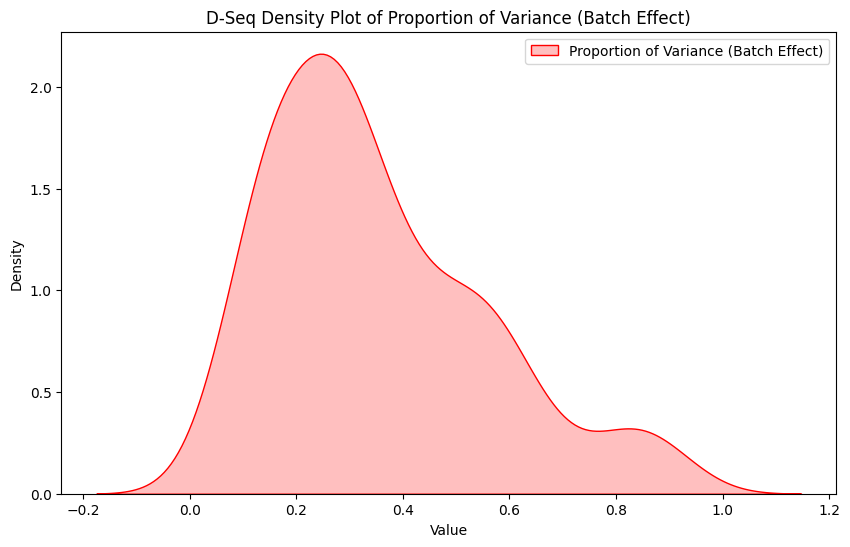

In [328]:
plt.figure(figsize=(10, 6))

# Density plot for 'Proportion of Variance (Batch Effect)'
sns.kdeplot(dseq_factor_attributes['Proportion of Variance (Batch Effect)'], label='Proportion of Variance (Batch Effect)', fill=True, color = 'red')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('D-Seq Density Plot of Proportion of Variance (Batch Effect)')
plt.legend()
plt.show()

# Factor-Factor Heat Map